In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

  Activating environment at `C:\Users\hilld\Documents\git\ocrl\ocrl_quadruped_mpc\Project.toml`


## Dynamics

In [197]:
function skew_symmetric(r::Vector) #function to convert vector to cross-product skew-symmetric matrix
    R = [0 -r[3] r[2]; r[3] 0 -r[1]; -r[2] r[1] 0]
    return R
end

function R_z(sigma::Real)
     R = [cos(sigma) sin(sigma) 0; -sin(sigma) cos(sigma) 0; 0 0 1]
    return R
end

#dynamics function of quadruped
function dynamics(model::NamedTuple, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector)
    #state is defined as [x,theta,x_dot,theta_dot]^T
    #force is defined as [fl,fr,bl,br]^T where each one is composed of x,y,z forces
    
    m, J = model.m, model.J

    A = vcat(hcat(zeros(6,6), vcat(hcat(R_z(x[6]),zeros(3,3)),hcat(zeros(3,3),Matrix{Float64}(I,3,3)))), zeros(6,12)) #A matrix
    #B1 is first 9 rows of B matrix, first 6 rows are zeros, next rows are F = ma
    B1 = vcat(zeros(6,12), 1/m * hcat(hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3)),hcat(Matrix{Float64}(I,3,3),Matrix{Float64}(I,3,3))))
    #B2 is last 3 rows of B matrix effecting theta_dot, these are tau = J*theta_dot
    B2 = hcat(hcat(J \ skew_symmetric(r1 - x[1:3]), J \ skew_symmetric(r2 - x[1:3])),hcat(J \ skew_symmetric(r3 - x[1:3]), J \ skew_symmetric(r4 - x[1:3])))
    B = vcat(B1,B2) #add B1 to B2 to get full B matrix
    C = vcat(vcat(zeros(8),1),zeros(3)) #gravity term    
    
    Ag = vcat(hcat(A,C),zeros(1,13))
    Bg = vcat(B,zeros(1,12))
    
    x_dot = Ag * x + Bg * u #calculate x_dot (full state derivative)
    
#     @show Ag
#     @show Ag * x
#     @show Bg
#     @show Bg * u
    
    return x_dot
end

#rk4 function for discritization of dynamics
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, r1::Vector, r2::Vector, r3::Vector, r4::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u, r1, r2, r3, r4)
    k2 = dt * ode(model, x + k1/2, u, r1, r2, r3, r4)
    k3 = dt * ode(model, x + k2/2, u, r1, r2, r3, r4)
    k4 = dt * ode(model, x + k3,   u, r1, r2, r3, r4)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end


rk4 (generic function with 1 method)

## Reference Trajectory and Gait Planner

In [262]:
function reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)
    # creates a reference Xref and Uref for walker
    
    l, w, m, g = model.l, model.w, model.m, model.g
    
    N = Int(num_gaits * gait_period / dt + 2) #define N
    
    half_gait = Int(gait_period / (2 * dt))     #number of time steps in half a gait period
    quarter_gait = Int(gait_period / (4 * dt))  #number of time steps in a quarter of a gait period
    
    fl_s = zeros(N) #initialize fl_s etc. These are the gait timings
    fl_s[1] = 1
    fl_s[N] = 1
    fr_s = zeros(N)
    fr_s[1] = 1
    fr_s[N] = 1
    bl_s = zeros(N)
    bl_s[1] = 1    
    bl_s[N] = 1
    br_s = zeros(N)
    br_s[1] = 1
    br_s[N] = 1
    
    #diagonal trot gait
    state = 0
    for i = 2:half_gait:N-1  #every quarter gait, switch feet
        if(state == 0)
            fl_s[i:i+half_gait-1] = zeros(half_gait)
            fr_s[i:i+half_gait-1] = ones(half_gait)
            bl_s[i:i+half_gait-1] = ones(half_gait)
            br_s[i:i+half_gait-1] = zeros(half_gait)
            state = 1
        elseif(state == 1)
            fl_s[i:i+half_gait-1] = ones(half_gait)
            fr_s[i:i+half_gait-1] = zeros(half_gait)
            bl_s[i:i+half_gait-1] = zeros(half_gait)
            br_s[i:i+half_gait-1] = ones(half_gait)
            state = 0
        end
    end
    
    #bear walk gait
#     state = 0
#     for i = 2:quarter_gait:N-1  #every quarter gait, switch feet
#         if(state == 0)
#             fl_s[i:i+quarter_gait-1] = zeros(quarter_gait)
#             fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             br_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             state = 1
#         elseif(state == 1)
#             fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             br_s[i:i+quarter_gait-1] = zeros(quarter_gait)
#             state = 2
#         elseif(state == 2)
#             fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             fr_s[i:i+quarter_gait-1] = zeros(quarter_gait)
#             bl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             br_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             state = 3
#         elseif(state == 3)
#             fl_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             fr_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             bl_s[i:i+quarter_gait-1] = zeros(quarter_gait)
#             br_s[i:i+quarter_gait-1] = ones(quarter_gait)
#             state = 0
#         end
#     end
    
#     @show fl_s
#     @show fr_s
#     @show bl_s
#     @show br_s
    
    Xref = [zeros(13) for i = 1:N] #initialize state reference trajectory
    
    v = (xg[3] - xic[3]) / ((N-1) * dt) #assuming straight line path, get constant velocity required
    
    for i = 1:N #fill in state reference trajectory
        Xref[i] = vcat(((N-i) * xic[1:6] + (i-1) * xg[1:6]) / (N-1), [v,0,0,0,0,0,g])
    end
    
#     Uref = [zeros(12) for i = 1:N-1] #initialize state reference trajectory
    
#     for i = 1:N-1
#         count = fl_s[i] + fr_s[i] + bl_s[i] + br_s[i]
#         Uref[i][3] = fl_s[i] * -m*g / count
#         Uref[i][6] = fr_s[i] * -m*g / count
#         Uref[i][9] = bl_s[i] * -m*g / count
#         Uref[i][12] = br_s[i] * -m*g / count
#     end
    
    r1 = [zeros(3) for i=1:N] #initialize r vectors
    r2 = [zeros(3) for i=1:N]
    r3 = [zeros(3) for i=1:N]
    r4 = [zeros(3) for i=1:N]
    
    r1[1] = [l/2 + Xref[1][1], w/2 + Xref[1][2], 0] #start standing up straight
    r2[1] = [l/2 + Xref[1][1], -w/2 + Xref[1][2], 0]
    r3[1] = [-l/2 + Xref[1][1], w/2 + Xref[1][2], 0]
    r4[1] = [-l/2 + Xref[1][1], -w/2 + Xref[1][2], 0]
    
    r1[N] = [l/2 + Xref[N][1], w/2 + Xref[N][2], 0] #end standing up straight
    r2[N] = [l/2 + Xref[N][1], -w/2 + Xref[N][2], 0]
    r3[N] = [-l/2 + Xref[N][1], w/2 + Xref[N][2], 0]
    r4[N] = [-l/2 + Xref[N][1], -w/2 + Xref[N][2], 0]
    
    for i = 2:N-1 #for each sequential half gait, set legs reaching past shoulders to start
        r1[i] = r1[i-1]
        r2[i] = r2[i-1]
        r3[i] = r3[i-1]
        r4[i] = r4[i-1]
        if((fl_s[i-1] == 0) & (fl_s[i] == 1))
            r1[i] = [l/2 + Xref[i][1] + gait_period/2 * v, w/2 + Xref[i][2], 0]
        end
        if((fr_s[i-1] == 0) & (fr_s[i] == 1))
            r2[i] = [l/2 + Xref[i][1] + gait_period/2 * v, -w/2 + Xref[i][2], 0]
        end
        if((bl_s[i-1] == 0) & (bl_s[i] == 1))
            r3[i] = [-l/2 + Xref[i][1] + gait_period/2 * v, w/2 + Xref[i][2], 0]
        end
        if((br_s[i-1] == 0) & (br_s[i] == 1))
            r4[i] = [-l/2 + Xref[i][1] + gait_period/2 * v, -w/2 + Xref[i][2], 0]
        end
    end
        
    return Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4
end

reference_trajectory (generic function with 1 method)

## Test Dynamics and Gait Planner

In [263]:
#model defined here
model = (g = -9.81, m = 5.0, J = diagm([1,5.2,5.8]), l = 1.0, w = 0.4, h = 0.6, mu = 0.5)
v = 0.2
dt = 0.01
gait_period = 2
num_gaits = 2
xic = [0,0,model.h,0,0,0,0,0,0,0,0,0]
xg = [v*gait_period*num_gaits,0,model.h,0,0,0,0,0,0,0,0,0]
@show xg

tf = N * dt 
t_vec = 0:dt:tf

#construct reference trajectory
Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4 = reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)

# Uref = [zeros(12) for i=1:N-1]

@show Xref[1]
@show Uref[1]
@show fl_s[1]
@show fr_s[1]
@show bl_s[1]
@show br_s[1]
@show r1[1]
@show r2[1]
@show r3[1]
@show r4[1]

x_dot = dynamics(model, Xref[1], Uref[1], r1[1], r2[1], r3[1], r4[1])

@show x_dot

# # calculate Jacobians
# As = [zeros(nx,nx) for i = 1:N-1]
# Bs = [zeros(nx,nu) for i = 1:N-1]
# for i = 1:N-1
#     As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r1[i], r2[i], r3[i], r4[i], dt), Xref[i])
#     Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r1[i], r2[i], r3[i], r4[i], dt), Uref[i])
# end
# #this C is our gravity term (not sure if this is done correctly)
# C = rk4(model, dynamics, zeros(12), zeros(12), r1[1], r2[1], r3[1], r4[1], dt)

# Xsim = [zeros(12) for i = 1:N]
# Xsim[1] = Xref[1]

# for i = 1:N-1
#     Xsim[i+1] = rk4(model, dynamics, Xsim[i], U[i], r1[i], r2[i], r3[i], r4[i], dt)
# end

# Xsim = hcat(Xsim...)

# display(plot(t_vec[1:end-1], Xsim[1:3,:]', lc = [:red :green :blue]))

# display(plot(t_vec[1:end-1], Xsim[4:6,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-1], fl_s)
# plot!(t_vec[1:end-1], fr_s)
# plot!(t_vec[1:end-1], bl_s)
# display(plot!(t_vec[1:end-1], br_s))
    
r1 = hcat(r1...)
r2 = hcat(r2...)
r3 = hcat(r3...)
r4 = hcat(r4...)
Xref = hcat(Xref...)

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], fl_s)
display(plot!(t_vec[1:end-1], r1[1:3,:]'))

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], fr_s)
display(plot!(t_vec[1:end-1], r2[1:3,:]'))
    
plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], bl_s)
display(plot!(t_vec[1:end-1], r3[1:3,:]'))

plot(t_vec[1:end-1], Xref[1,:])
plot!(t_vec[1:end-1], br_s)
display(plot!(t_vec[1:end-1], r4[1:3,:]'))
    
# plot(t_vec[1:end-2], Urefm[1:3,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FL")
# display(plot!(t_vec[1:end-2], Um[1:3,:]', lc = [:red :green :blue]))
#     plot(t_vec[1:end-2], Urefm[4:6,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls FR")
# display(plot!(t_vec[1:end-2], Um[4:6,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-2], Urefm[7:9,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BL")
# display(plot!(t_vec[1:end-2], Um[7:9,:]', lc = [:red :green :blue]))
# plot(t_vec[1:end-2], Urefm[10:12,:]', ls = :dash, lc = [:red :green :blue],
# xlabel = "time (s)", ylabel = "controls", title = "Controls BR")
# display(plot!(t_vec[1:end-2], Um[10:12,:]', lc = [:red :green :blue]))

xg = [0.8, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


LoadError: MethodError: no method matching (::Colon)(::Int64, ::Float64, ::Vector{Vector{Float64}})
[0mClosest candidates are:
[0m  (::Colon)(::T, ::AbstractFloat, [91m::T[39m) where T<:Real at range.jl:16
[0m  (::Colon)(::Real, ::Real) at range.jl:3
[0m  (::Colon)(::T, ::Any, [91m::T[39m) where T<:Real at range.jl:41
[0m  ...

## Solve


ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+000  -2.385e+005  +6e+005  4e-002  8e-001  1e+000  5e+001    ---    ---    2  2  - |  -  - 
 1  +2.087e+003  -6.495e+004  +1e+005  1e-002  5e-004  3e+000  1e+001  0.8143  5e-002   3  1  2 |  0  0
 2  +3.534e+003  -5.700e+004  +1e+005  1e-002  9e-004  8e+000  9e+000  0.4985  6e-001   2  2  2 |  0  0
 3  +1.024e+003  -9.221e+003  +2e+004  2e-003  5e-004  2e+000  2e+000  0.9007  7e-002   2  2  2 |  0  0
 4  +9.997e+002  -6.417e+003  +1e+004  1e-003  4e-004  2e+000  1e+000  0.5273  4e-001   1  1  2 |  0  0
 5  +5.148e+002  -1.873e+003  +4e+003  4e-004  1e-004  7e-001  3e-001  0.7687  1e-001   2  2  2 |  0  0
 6  +5.143e+002  -1.031e+003  +2e+003  3e-004  9e-005  5e-001  2e-001  0.6157  4e-001   1  1  1 |  0  0
 7  +4.228e+002  -7.493e+001  +8e+002  9e-005  3e-005  2e-001  7e-002  0.7323  8e-002  

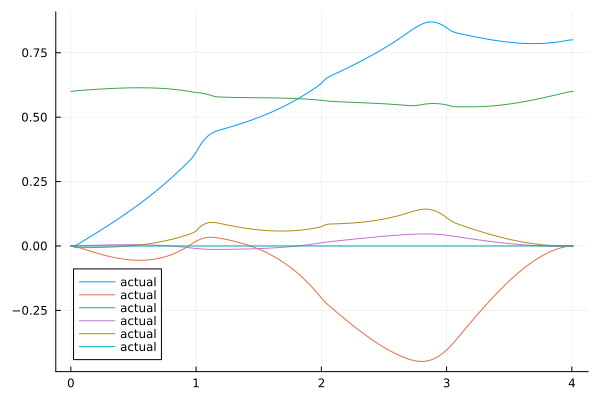

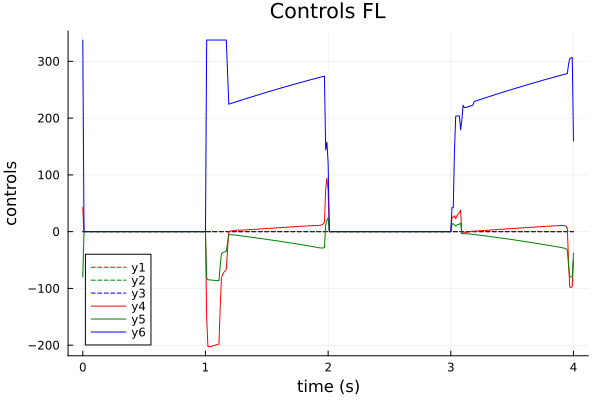

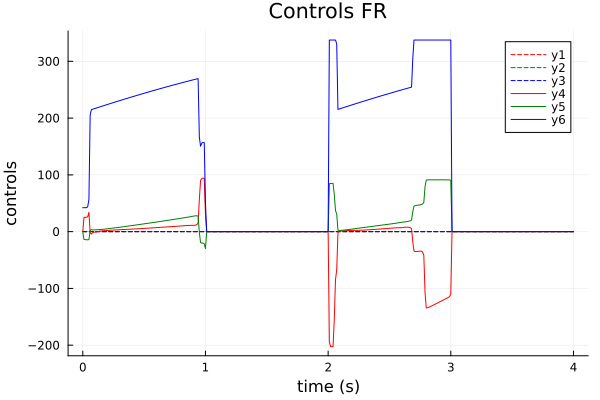

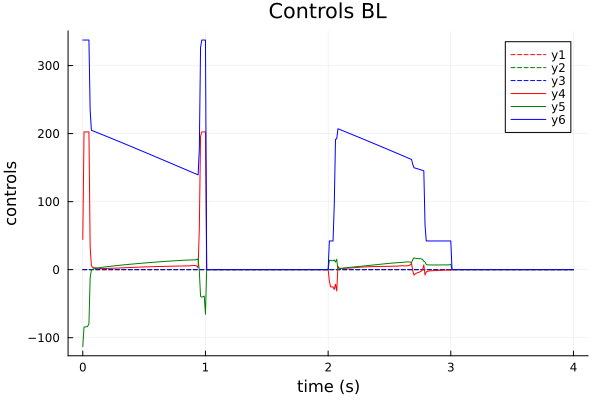

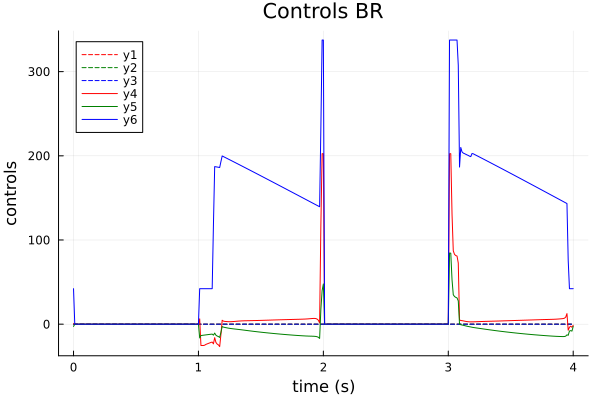

In [264]:
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

#model defined here
model = (g = -9.81, m = 43.0, J = diagm([0.41,2.1,2.1]), l = 1.0, w = 0.4, h = 0.6, mu = 0.6)
v = 0.2
dt = 0.01
gait_period = 2
num_gaits = 2
xic = [0,0,model.h,0,0,0,0,0,0,0,0,0]
xg = [v*gait_period*num_gaits,0,model.h,0,0,0,0,0,0,0,0,0]

#construct reference trajectory
Xref, N, fl_s, fr_s, bl_s, br_s, r1, r2, r3, r4 = reference_trajectory(model, xic, xg, dt, gait_period, num_gaits)

Uref = [zeros(12) for i=1:N-1]

# @show r1
# @show r2
# @show r3
# @show r4

tf = N * dt 
t_vec = 0:dt:tf 

nx = 12
nu = 12

# LQR tracking cost to be used in ILC 
Q = diagm([1,1,1,1,1,1,10,10,10,1,1,1,0])
R = 0*diagm(ones(nu))
Qf = 100*Q
            
# calculate Jacobians
As = [zeros(nx,nx) for i = 1:N-1]
Bs = [zeros(nx,nu) for i = 1:N-1]
for i = 1:N-1
    As[i] = FD.jacobian(x -> rk4(model, dynamics, x, Uref[i], r1[i], r2[i], r3[i], r4[i], dt), Xref[i])
    Bs[i] = FD.jacobian(u -> rk4(model, dynamics, Xref[i], u, r1[i], r2[i], r3[i], r4[i], dt), Uref[i])
end

# @show As[6]
# @show As[7]
# @show Bs[6]
# @show Bs[7]

# create variables 
X = cvx.Variable(nx+1, N) #add extra state dimension for gravity
U = cvx.Variable(nu, N-1)

# cost function (tracking cost on Xref, Uref)
cost = 0.0
for k = 1:N-1
    # add stagewise cost 
    cost += 0.5*cvx.quadform(X[:,k] - Xref[k],Q) + 0.5*cvx.quadform(U[:,k],R)
end

cost += 0.5*cvx.quadform(X[:,N] - Xref[N],Qf)

# problem instance
prob = cvx.minimize(cost)

# initial condition constraint
prob.constraints += (X[:,1] == Xref[1])

# final condition constraint
prob.constraints += (X[:,N] == Xref[N])

# dynamics constraints
for k = 1:(N-1)
    prob.constraints += (X[:,k+1] == As[k]*X[:,k] + Bs[k]*U[:,k])
end

#height constraint (no limbo)
for k = 1:N
    prob.constraints += (X[3,k] > model.h * 0.9)
    prob.constraints += (X[3,k] < model.h * 1.1)
end

# gait constraints (only able to use feet when the are on the ground)
for k = 1:N-1
    if fl_s[k] == 0
        prob.constraints += (U[3,k] == 0)
    else
        prob.constraints += (U[3,k] >= -model.m*model.g*0.1)  
        prob.constraints += (U[3,k] <= -model.m*model.g*0.8)        
    end
    if fr_s[k] == 0
        prob.constraints += (U[6,k] == 0)
    else
        prob.constraints += (U[6,k] >= -model.m*model.g*0.1)
        prob.constraints += (U[6,k] <= -model.m*model.g*0.8)   
    end
    if bl_s[k] == 0
        prob.constraints += (U[9,k] == 0)
    else
        prob.constraints += (U[9,k] >= -model.m*model.g*0.1) 
        prob.constraints += (U[9,k] <= -model.m*model.g*0.8)  
    end
    if br_s[k] == 0
        prob.constraints += (U[12,k] == 0)
    else
        prob.constraints += (U[12,k] >= -model.m*model.g*0.1) 
        prob.constraints += (U[12,k] <= -model.m*model.g*0.8)  
    end
end

#friction constraints (friction cone)
for k = 1:N-1
    #front left
    prob.constraints += (U[1,k] <= model.mu * U[3,k])
    prob.constraints += (U[1,k] >= -model.mu * U[3,k])
    prob.constraints += (U[2,k] <= model.mu * U[3,k])
    prob.constraints += (U[2,k] >= -model.mu * U[3,k])
    #front right
    prob.constraints += (U[4,k] <= model.mu * U[6,k])
    prob.constraints += (U[4,k] >= -model.mu * U[6,k])
    prob.constraints += (U[5,k] <= model.mu * U[6,k])
    prob.constraints += (U[5,k] >= -model.mu * U[6,k])
    #back left
    prob.constraints += (U[7,k] <= model.mu * U[9,k])
    prob.constraints += (U[7,k] >= -model.mu * U[9,k])
    prob.constraints += (U[8,k] <= model.mu * U[9,k])
    prob.constraints += (U[8,k] >= -model.mu * U[9,k])
    #back right
    prob.constraints += (U[10,k] <= model.mu * U[12,k])
    prob.constraints += (U[10,k] >= -model.mu * U[12,k])
    prob.constraints += (U[11,k] <= model.mu * U[12,k])
    prob.constraints += (U[11,k] >= -model.mu * U[12,k])
end

cvx.solve!(prob, ECOS.Optimizer; silent_solver = false) #solver does the heavy lifting

# get X and U
X = vec_from_mat(X.value)
U = vec_from_mat(U.value)

#simulate to see if our dynamics are right
Xsim = [zeros(12) for i = 1:N]
Xsim[1] = Xref[1]

for i = 1:N-1
    Xsim[i+1] = rk4(model, dynamics, Xsim[i], U[i], r1[i], r2[i], r3[i], r4[i], dt)
end

# @show Xsim[1]
# @show U[1]
# @show Xsim[2]
# @show r1[1]
# @show r2[1]
# @show r3[1]
# @show r4[1]
# @show As[1]
# @show Bs[1]
# @show C

#plots
Xm= hcat(X...)
Um = hcat(U...)
Xrefm = hcat(Xref...)
Urefm = hcat(Uref...)
Xsim = hcat(Xsim...)

# @show (hcat(r3...) - Xrefm[1:3,:])[1:3,:]

# plot(t_vec[1:end-1], Xsim[1:6,:]', ls = :dash, label = "reference",
# xlabel = "t (s)", ylabel = "state", title = "State")
display(plot(t_vec[1:end-1], Xm[1:6,:]', label = "actual"))
    
plot(t_vec[1:end-2], Urefm[1:3,:]', ls = :dash, lc = [:red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls FL")
display(plot!(t_vec[1:end-2], Um[1:3,:]', lc = [:red :green :blue]))
    plot(t_vec[1:end-2], Urefm[4:6,:]', ls = :dash, lc = [:red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls FR")
display(plot!(t_vec[1:end-2], Um[4:6,:]', lc = [:red :green :blue]))
plot(t_vec[1:end-2], Urefm[7:9,:]', ls = :dash, lc = [:red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls BL")
display(plot!(t_vec[1:end-2], Um[7:9,:]', lc = [:red :green :blue]))
plot(t_vec[1:end-2], Urefm[10:12,:]', ls = :dash, lc = [:red :green :blue],
xlabel = "time (s)", ylabel = "controls", title = "Controls BR")
display(plot!(t_vec[1:end-2], Um[10:12,:]', lc = [:red :green :blue]))